## Summarising data across repeated runs of same workload 

In [5]:
import json
import pickle
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [37]:
# GLOBAL VARIABLES / PARAMETERS
WORKLOAD = "WITH_ISTIO_WITHOUT_WORKLOAD"
TRACE_LOGS = f"{WORKLOAD}/"
PARSED_OUTPUTS = f"parsedOutputs/{WORKLOAD}"
NUM_RUNS = 5
FUNC_BLACKLIST = {"BLANK", "do_syscall_64()",'schedule()'}
PROCESSES=['containerd', 'kube-controller', 'HomeTimelineSer', 'UserMentionServ', 'envoy', 'UserTimelineSer', 'pilot-agent','calico-node', 'MediaService',  'apiserver', 'calico-typha','PostStorageServ','ComposePostServ','kube-apiserver', 'kubelet', 'mongod', 'UniqueIdService', 'openresty', 'SocialGraphServ', 'etcd', 'TextService', 'redis-server',  'UrlShortenServi', 'UserService','node', 'memcached','ip6tables','others']
COLORS=['#201923','#fcff5d','#7dfc00','#0ec434','#228c68','#8ad8e8','#235b54','#29bdab','#3998f5','#37294f','#277da7','#3750db','#f22020','#991919','#ffcba5','#e68f66','#c56133','#96341c','#632819','#ffc413','#f47a22','#2f2aa0','#b732cc','#772b9d','#f07cab','#d30b94','#edeff3','#c3a5b4','#946aa2','#5d4c86']

In [7]:
COLOR_MAP={}
for i in range(len(PROCESSES)):
    COLOR_MAP[PROCESSES[i]]=COLORS[i]


#### Identifying most important functions by count

In [8]:

def get_runs():
    runs = []
    for i in range(NUM_RUNS):
        with open(os.path.join(PARSED_OUTPUTS, f'{i}.json'), "r") as fd:
            data = json.load(fd)
            runs.append(data)
    return runs


Sample JSON
```json
"2016654": [
    {
      "function_name": "do_syscall_64() ",
      "time": 100134.8,
      "children": [
        {
          "function_name": "__x64_sys_epoll_wait() ",
          "time": 100129.9,
          "children": [
            {
              "function_name": "do_epoll_wait() ",
              "time": 100129.6,
              "children": [
                {
                  "function_name": "__fdget() ",
                  "time": 0.862,
                  "children": [
                    {
                      "function_name": "__fget_light();",
                      "time": 0.561,
                      "children": []
                    }
                  ]
                }
```

In [9]:
def get_function_counts(run, recurse=False):
    count = {}

    def get_counts(function, count, recurse):
        func_name = function["function_name"].strip().strip(";")
        if func_name not in FUNC_BLACKLIST:
            count[func_name] = count.get(func_name, 0) + 1
        if recurse:
            for child in function["children"]:
                get_counts(child, count, recurse)
    for pid in run:
        for function in run[pid]:
            get_counts(function, count, recurse)
        
    return count

def plot_counts(count, title=WORKLOAD, maxnum=20):
    maxnum = min(maxnum, len(count))
    x = sorted(list(count.keys()), key=lambda x: count[x], reverse=True)[ :maxnum]
    y = [count[_] for _ in x]
    print(x[0])

    plt.figure(figsize=(10, 4))
    plt.xticks(np.arange(len(x)), x, rotation=90)
    plt.title(title)
    plt.bar(x, y)
    plt.show()
    del x, y

In [10]:
def get_pid_mapping(file):
    pid_mapping={}
    with open(file,'r') as f:
        for line in f.readlines():
            
            pid,*name= line.split()
            if(type(name)==list):
                name=' '.join(name)
            pid_mapping[pid]=name
            
    return pid_mapping

In [11]:
def get_function_counts_per_process(run, run_no, recurse=False):
    count = {}
    process_count={}
    pids = get_pid_mapping(f'{WORKLOAD}/{run_no}.saved_cmdlines')
    def get_counts(function, count, recurse,pid):
        func_name = function["function_name"].strip().strip(";")
        if func_name not in FUNC_BLACKLIST:
            count[func_name] = count.get(func_name, {})
            count[func_name][pid] = count.get(func_name).get(pid,0) + 1
        if recurse:
            for child in function["children"]:
                get_counts(child, count, recurse,pid)
    for pid in run:
        # count[pid]={}
        for function in run[pid]:
            get_counts(function, count, recurse,pid)
    for function,data in count.items():
        process_count[function]={}
        for pid in data:
            if pid in pids:
                process_count[function][pids[pid]]=process_count.get(function).get(pids[pid],0) + count[function][pid]
                process_count[function]['total']=process_count.get(function).get('total',0) + count[function][pid]
    return process_count
        
def plot_stacked_counts(count, title=WORKLOAD, maxnum=20):
    processes= set()
    for data in count.values():
        for proc in data:
            if proc != 'total':
                processes.add(proc)
    processes= sorted(list(processes))
    maxnum = min(maxnum, len(count))
    x = sorted(list(count.keys()), key=lambda x: count[x]['total'], reverse=True)[ :maxnum]
    yold=[0 for _ in range(len(x))]
    plt.figure(figsize=(16, 6))
    others=[0 for _ in range(len(x))]
    for proc in processes:
        if(proc in PROCESSES):
            y=[0 for _ in range(len(x))]
            for i in range(len(x)):
                y[i] = count[x[i]].get(proc,0)
            plt.bar(x,y,bottom=yold,color=COLOR_MAP[proc],label=proc)
            yold = [yold[i] + y[i] for i in range (len(y))]
        else:
            for i in range(len(x)):
                others[i] += count[x[i]].get(proc,0)
    plt.bar(x,others,bottom=yold,color=COLOR_MAP['others'],label='others')

    plt.xticks(np.arange(len(x)), x, rotation=90)
    plt.legend()
    plt.title(title)
    plt.show()
    del x, y


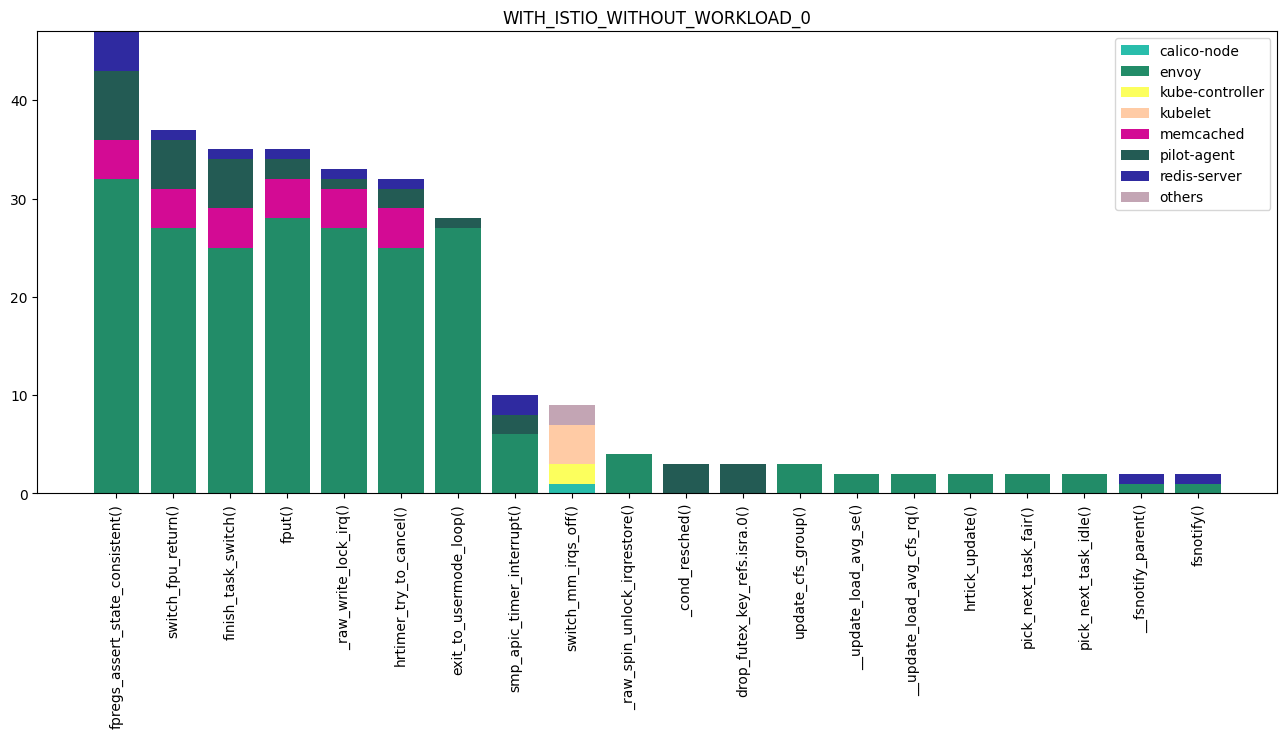

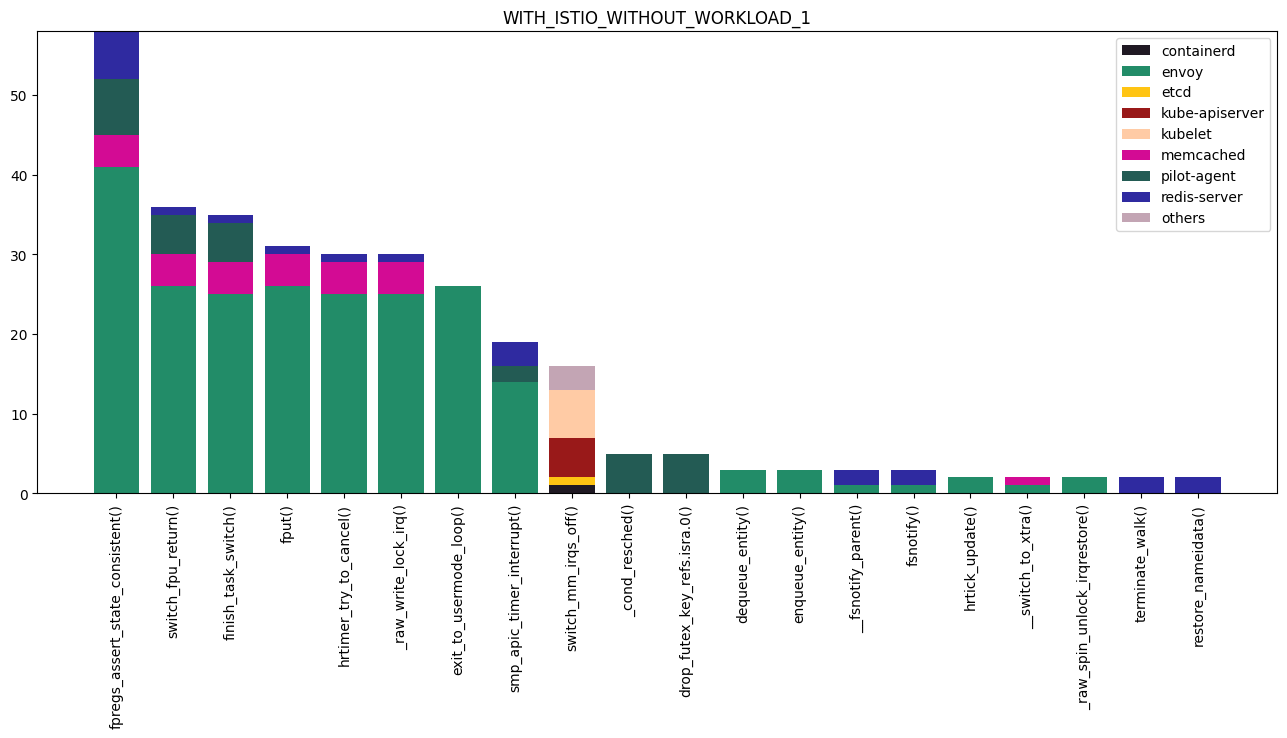

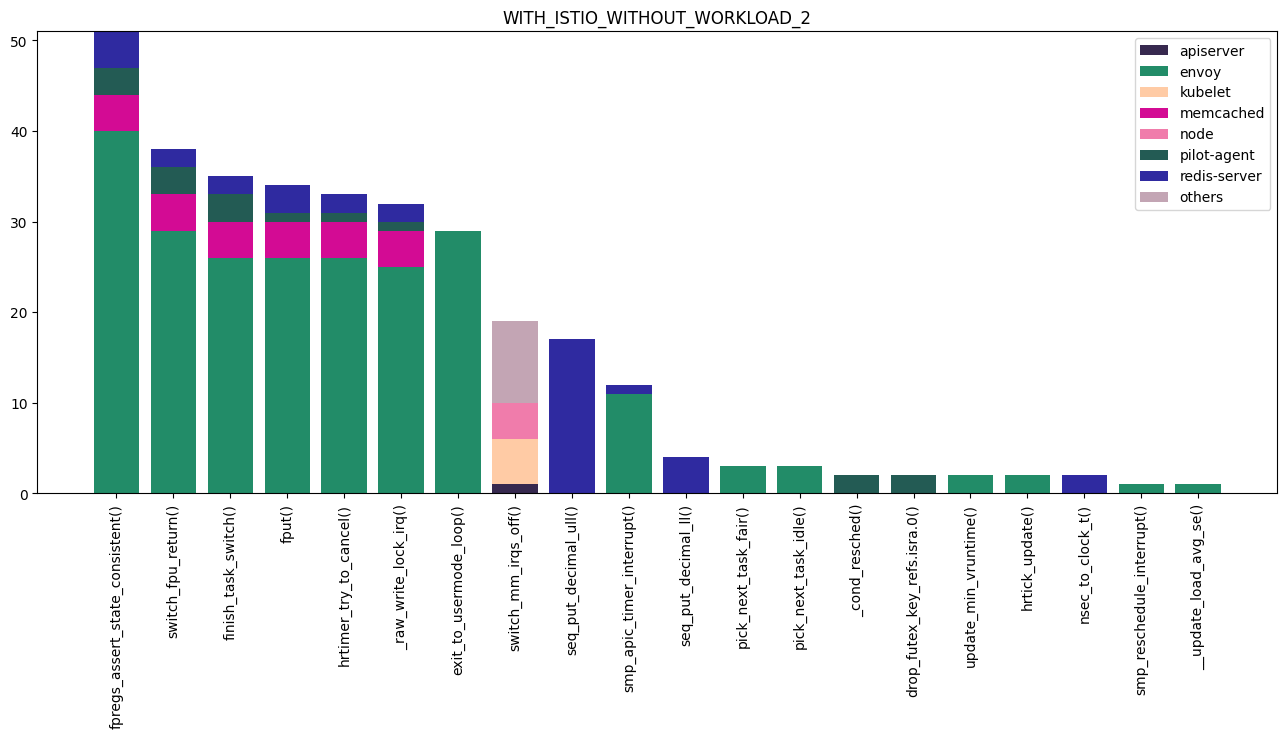

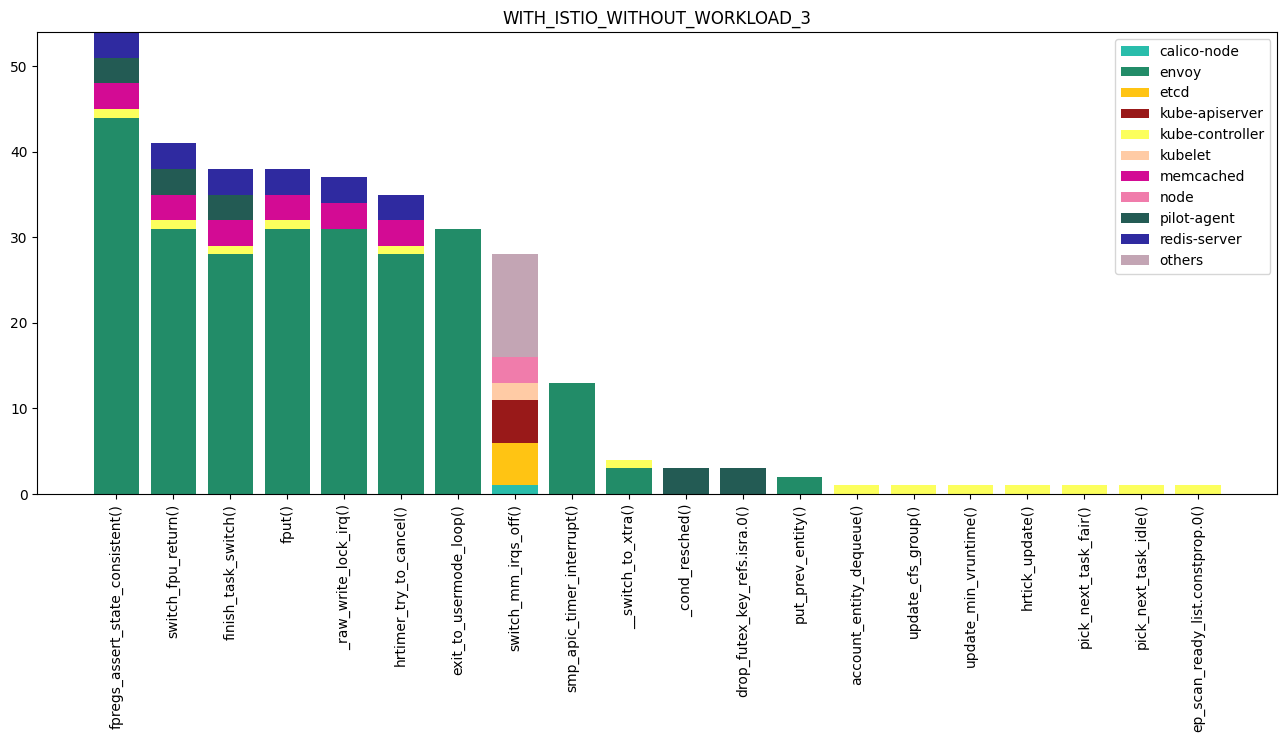

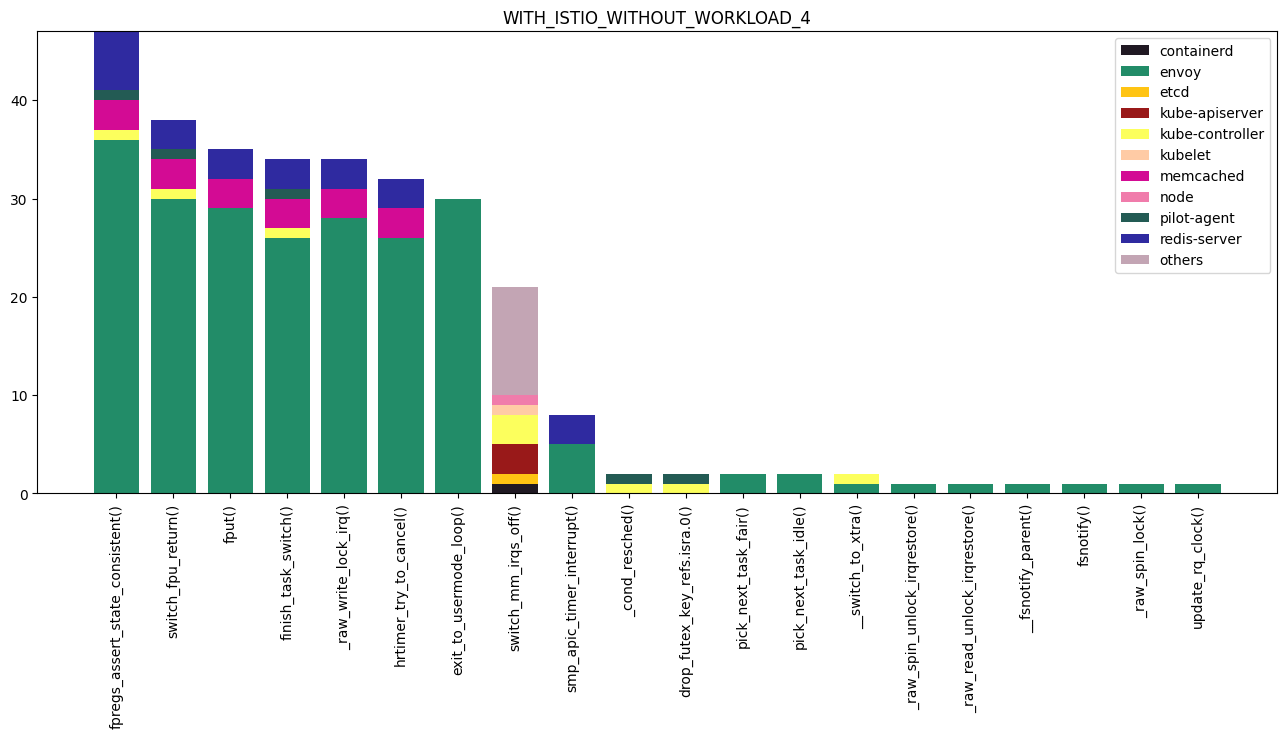

In [12]:
runs = get_runs()
for i in range(NUM_RUNS):
    count = get_function_counts_per_process(runs[i],i)
    plot_stacked_counts(count, title=f"{WORKLOAD}_{i}")

Points of Note
* fpregs_assert_state_consistent() is the most called function call consistenctly
* The function call counts are identical across the runs
* There are a total of only around 10-13 functions called in the idle runs at the top level of the callgraph

#### Parsing the callgraph recursively

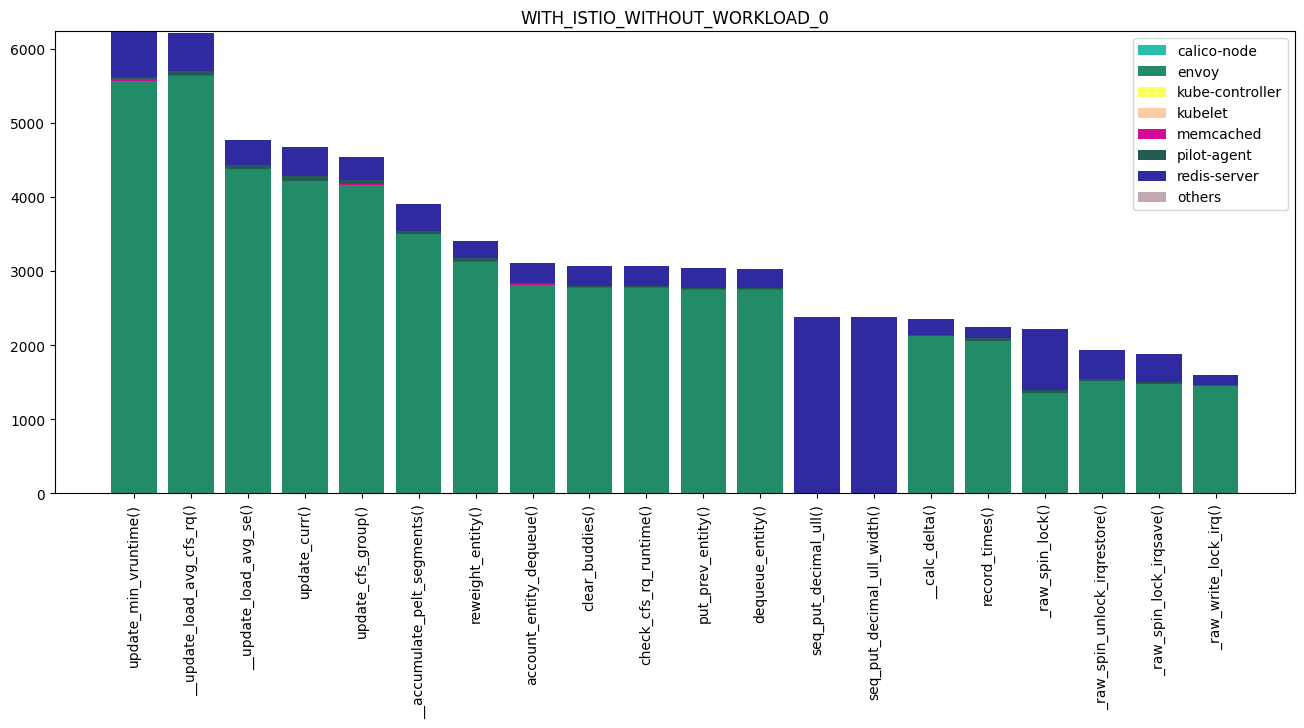

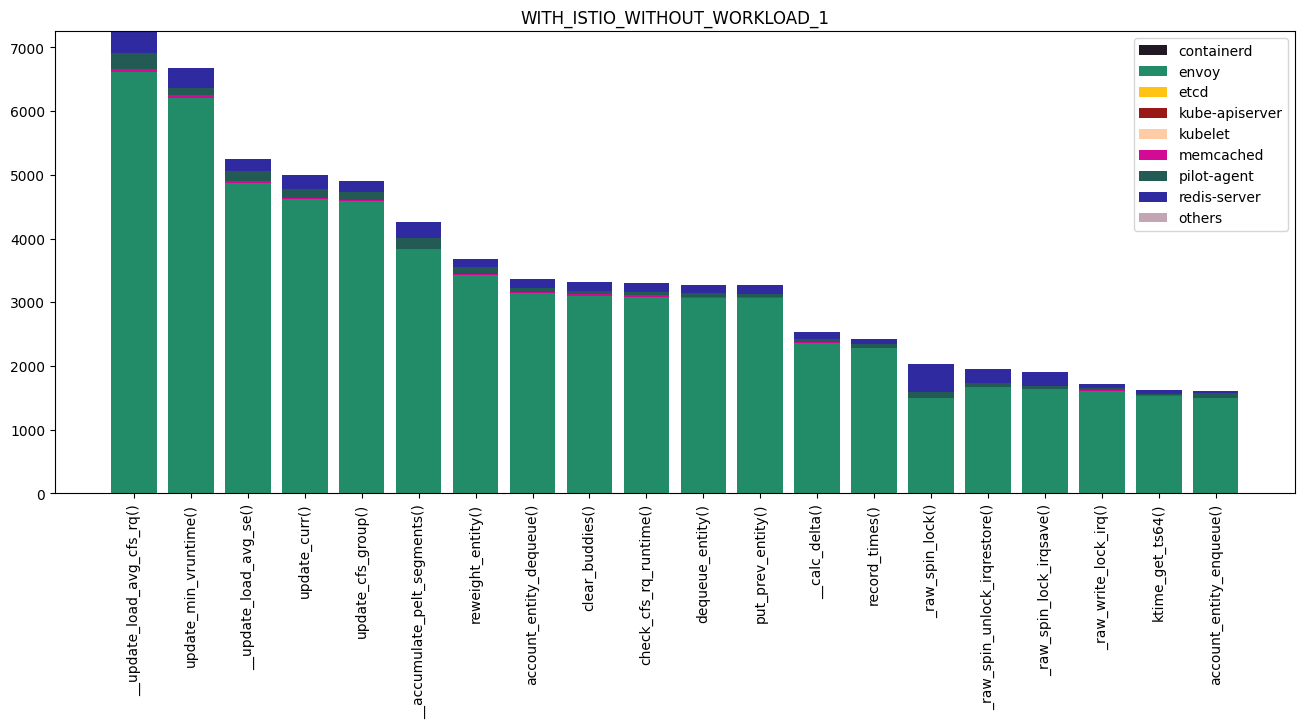

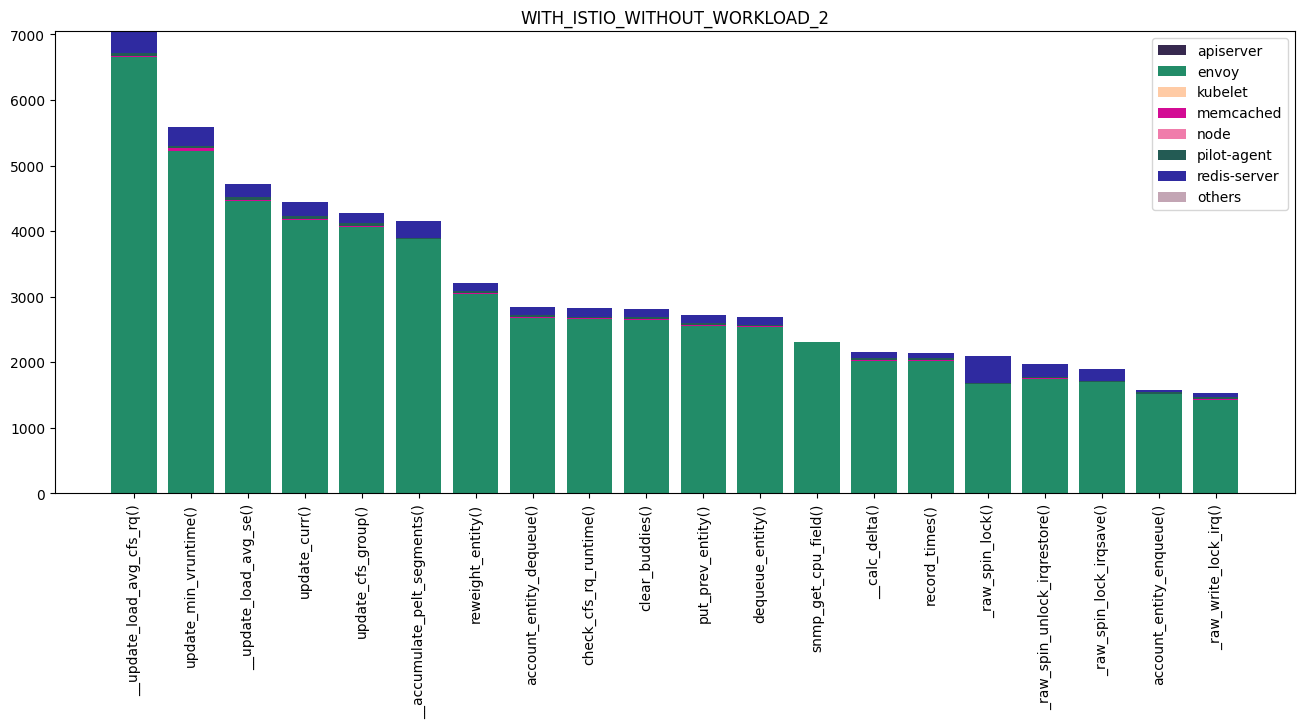

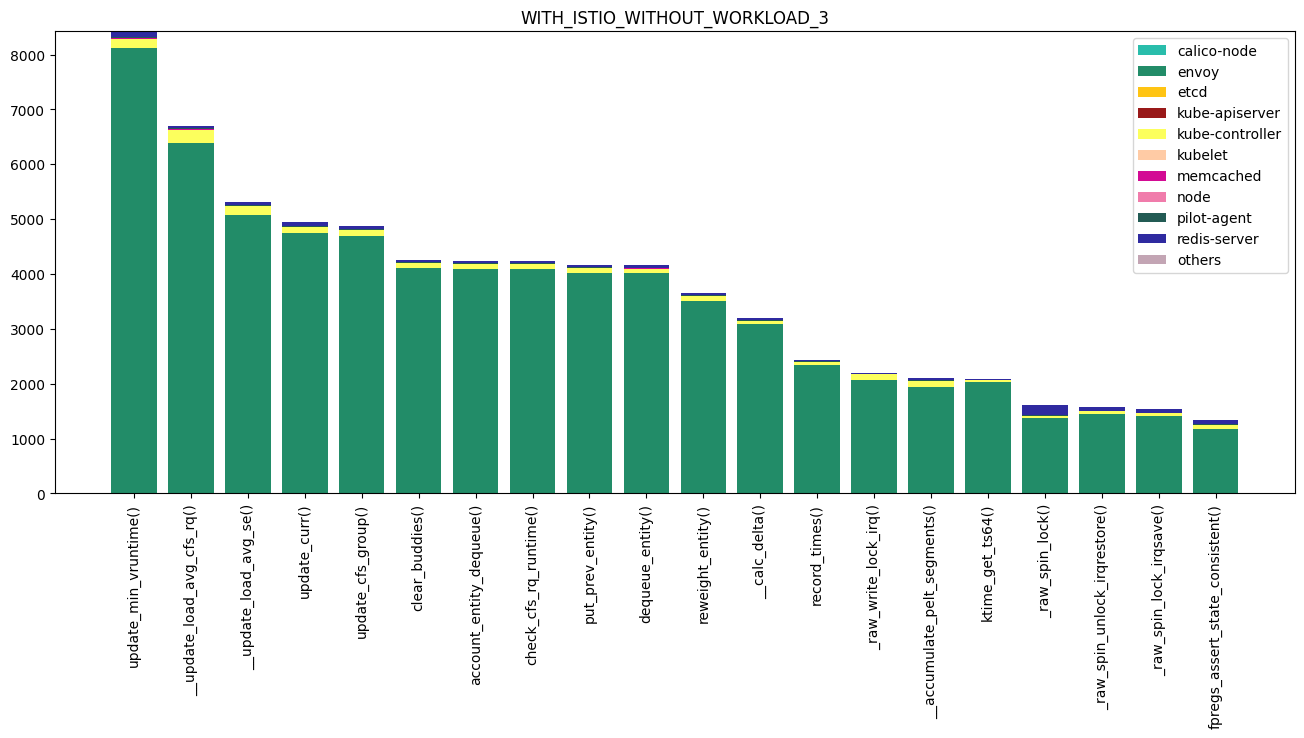

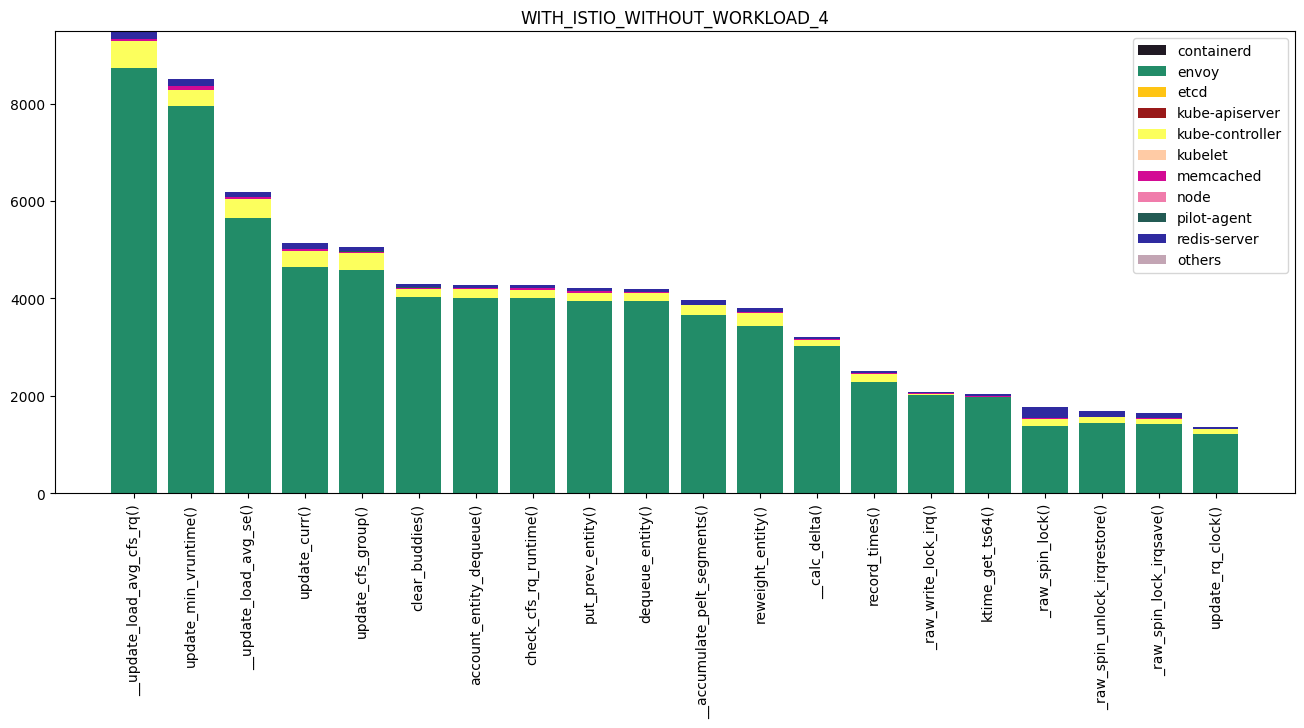

In [13]:
runs = get_runs()
for i in range(NUM_RUNS):
    count = get_function_counts_per_process(runs[i],i,recurse=True)
    plot_stacked_counts(count, title=f"{WORKLOAD}_{i}")

With recursion the most called function is update_load_avg_cfs_rq() which is mostly called by istio envoy. It updates the cfs_rq's load/util averages. (completley fair scheduler's queue). Most of the functions are called by envoy process

In [7]:
function_counts = [get_function_counts(run, recurse=True) for run in runs]

with open(f"pickles/function_counts/{WORKLOAD}.pickle", "wb") as f:
    pickle.dump(function_counts, file=f)

In [8]:
print(len(function_counts[0]), len(function_counts[1]), len(function_counts[2]))

708 680 1001


In [9]:
for i in range(NUM_RUNS):
    for j in range(NUM_RUNS):
        if i == j:
            continue

        print(f"Calls in {i} but not in {j} ", 
            set(function_counts[i].keys()).difference(set(function_counts[j].keys())), sep="\n", end="\n")
        print()

Calls in 0 but not in 1 
{'restore_altstack()', 'recalc_sigpending_tsk()', 'fpu__clear()', 'copy_fpstate_to_sigframe()', 'restore_sigcontext()', 'apparmor_sk_free_security()', 'dequeue_signal()', 'sock_disable_timestamp()', 'smp_reschedule_interrupt()', 'fpregs_mark_activate()', 'do_signal()', '__set_task_blocked()', 'copy_siginfo_to_user()', 'estimation_timer [ip_vs]()', 'do_sigaltstack.constprop.0()', 'get_sigframe.isra.0.constprop.0()', 'cgroup_sk_free()', 'free_uid()', 'uprobe_deny_signal()', 'security_sk_free()', 'setup_sigcontext()', 'bpf_sk_storage_free()', 'fpu__drop()', 'get_signal()', '__sk_destruct()', 'udp_rmem_release()', 'path_put()', '__fpu__restore_sig()', 'fpu__restore_sig()', 'recalc_sigpending()', '__dequeue_signal()', 'fpstate_init()', 'inet_sock_destruct()', 'scheduler_ipi()', '__sigqueue_free.part.0()', 'udp_destruct_sock()', '__ia32_sys_rt_sigreturn()', 'signal_setup_done()', 'set_current_blocked()', 'fpu__alloc_mathframe()', '__set_current_blocked()', 'mem_cgrou

In [10]:
def get_count_diff(function_counts):
    count_diff = {}
    for i in range(NUM_RUNS):
        for j in range(NUM_RUNS):
            if i==j:
                continue
            count_diff[f"{i}-{j}"]= {}
            for function in function_counts[i].keys():
                lhs = function_counts[i].get(function, 0) 
                rhs = function_counts[j].get(function, 0)
                if lhs <= rhs: 
                    continue
                count_diff[f"{i}-{j}"][function] = (lhs - rhs) / lhs * 100
    return count_diff


In [11]:
diff_count = get_count_diff(function_counts=function_counts)

In [12]:
[(x, diff_count["0-1"][x]) for x in sorted(diff_count["0-1"], key=lambda x: diff_count["0-1"][x], reverse=True)]

[('__sk_destruct()', 100.0),
 ('udp_destruct_sock()', 100.0),
 ('udp_rmem_release()', 100.0),
 ('inet_sock_destruct()', 100.0),
 ('sock_disable_timestamp()', 100.0),
 ('bpf_sk_storage_free()', 100.0),
 ('cgroup_sk_free()', 100.0),
 ('mem_cgroup_sk_free()', 100.0),
 ('security_sk_free()', 100.0),
 ('apparmor_sk_free_security()', 100.0),
 ('path_put()', 100.0),
 ('estimation_timer [ip_vs]()', 100.0),
 ('smp_reschedule_interrupt()', 100.0),
 ('scheduler_ipi()', 100.0),
 ('do_signal()', 100.0),
 ('get_signal()', 100.0),
 ('uprobe_deny_signal()', 100.0),
 ('dequeue_signal()', 100.0),
 ('__dequeue_signal()', 100.0),
 ('__sigqueue_free.part.0()', 100.0),
 ('free_uid()', 100.0),
 ('recalc_sigpending()', 100.0),
 ('recalc_sigpending_tsk()', 100.0),
 ('get_sigframe.isra.0.constprop.0()', 100.0),
 ('fpu__alloc_mathframe()', 100.0),
 ('copy_fpstate_to_sigframe()', 100.0),
 ('copy_siginfo_to_user()', 100.0),
 ('setup_sigcontext()', 100.0),
 ('fpu__clear()', 100.0),
 ('fpu__drop()', 100.0),
 ('fpsta

In [13]:
[(x, diff_count["0-2"][x]) for x in sorted(diff_count["0-2"], key=lambda x: diff_count["0-2"][x], reverse=True)]

[('__sk_destruct()', 100.0),
 ('udp_destruct_sock()', 100.0),
 ('inet_sock_destruct()', 100.0),
 ('sock_disable_timestamp()', 100.0),
 ('bpf_sk_storage_free()', 100.0),
 ('cgroup_sk_free()', 100.0),
 ('mem_cgroup_sk_free()', 100.0),
 ('security_sk_free()', 100.0),
 ('apparmor_sk_free_security()', 100.0),
 ('sock_free_inode()', 100.0),
 ('new_sync_write()', 100.0),
 ('estimation_timer [ip_vs]()', 100.0),
 ('mod_timer()', 100.0),
 ('lock_timer_base()', 100.0),
 ('detach_if_pending()', 100.0),
 ('__internal_add_timer()', 100.0),
 ('calc_wheel_index()', 100.0),
 ('enqueue_timer()', 100.0),
 ('trigger_dyntick_cpu.isra.0()', 100.0),
 ('rcu_gp_kthread_wake()', 100.0),
 ('swake_up_one()', 100.0),
 ('swake_up_locked.part.0()', 100.0),
 ('tcp_write_timer()', 100.0),
 ('tcp_write_timer_handler()', 100.0),
 ('__sk_mem_reclaim()', 100.0),
 ('__sk_mem_reduce_allocated()', 100.0),
 ('do_signal()', 100.0),
 ('get_signal()', 100.0),
 ('uprobe_deny_signal()', 100.0),
 ('dequeue_signal()', 100.0),
 ('__d

In [14]:
[(x, diff_count["1-0"][x]) for x in sorted(diff_count["1-0"], key=lambda x: diff_count["1-0"][x], reverse=True)]

[('delayed_work_timer_fn()', 100.0),
 ('__queue_work()', 100.0),
 ('get_work_pool()', 100.0),
 ('insert_work()', 100.0),
 ('can_migrate_task()', 100.0),
 ('kthread_is_per_cpu()', 100.0),
 ('detach_entity_cfs_rq()', 100.0),
 ('propagate_entity_cfs_rq()', 100.0),
 ('attach_task()', 100.0),
 ('__lock_sock()', 100.0),
 ('prepare_to_wait_exclusive()', 100.0),
 ('finish_wait()', 100.0),
 ('cursor_timer_handler()', 100.0),
 ('queue_work_on()', 100.0),
 ('__switch_to_xtra()', 80.0),
 ('tcp_write_timer()', 75.0),
 ('tcp_write_timer_handler()', 75.0),
 ('__sk_mem_reclaim()', 75.0),
 ('__sk_mem_reduce_allocated()', 75.0),
 ('tcp_poll()', 66.66666666666666),
 ('tcp_rcv_space_adjust()', 66.66666666666666),
 ('tcp_mstamp_refresh()', 66.66666666666666),
 ('ns_to_timespec64()', 66.66666666666666),
 ('__kfree_skb()', 66.66666666666666),
 ('sock_rfree()', 66.66666666666666),
 ('tcp_recv_timestamp()', 66.66666666666666),
 ('inet6_sendmsg()', 66.66666666666666),
 ('inet_send_prepare()', 66.66666666666666)

In [15]:
[(x, diff_count["2-0"][x]) for x in sorted(diff_count["2-0"], key=lambda x: diff_count["2-0"][x], reverse=True)]

[('__slab_alloc()', 100.0),
 ('___slab_alloc()', 100.0),
 ('__mmdrop()', 100.0),
 ('pgd_free()', 100.0),
 ('free_pages()', 100.0),
 ('free_pages.part.0()', 100.0),
 ('__free_pages()', 100.0),
 ('__free_pages_ok()', 100.0),
 ('__memcg_kmem_uncharge()', 100.0),
 ('__memcg_kmem_uncharge_memcg()', 100.0),
 ('page_counter_uncharge()', 100.0),
 ('page_counter_cancel()', 100.0),
 ('propagate_protected_usage()', 100.0),
 ('kernel_poison_pages()', 100.0),
 ('free_one_page()', 100.0),
 ('__mod_zone_page_state()', 100.0),
 ('destroy_context_ldt()', 100.0),
 ('epi_rcu_free()', 100.0),
 ('__d_free()', 100.0),
 ('hrtimer_reprogram()', 100.0),
 ('delayed_work_timer_fn()', 100.0),
 ('__queue_work()', 100.0),
 ('get_work_pool()', 100.0),
 ('insert_work()', 100.0),
 ('process_timeout()', 100.0),
 ('__x64_sys_socket()', 100.0),
 ('__sys_socket()', 100.0),
 ('__sock_create()', 100.0),
 ('security_socket_create()', 100.0),
 ('apparmor_socket_create()', 100.0),
 ('aa_af_perm()', 100.0),
 ('sock_alloc()', 10

In [16]:
[(x, diff_count["2-1"][x]) for x in sorted(diff_count["2-1"], key=lambda x: diff_count["2-1"][x], reverse=True)]

[('__slab_alloc()', 100.0),
 ('___slab_alloc()', 100.0),
 ('__mmdrop()', 100.0),
 ('pgd_free()', 100.0),
 ('free_pages()', 100.0),
 ('free_pages.part.0()', 100.0),
 ('__free_pages()', 100.0),
 ('__free_pages_ok()', 100.0),
 ('__memcg_kmem_uncharge()', 100.0),
 ('__memcg_kmem_uncharge_memcg()', 100.0),
 ('page_counter_uncharge()', 100.0),
 ('page_counter_cancel()', 100.0),
 ('propagate_protected_usage()', 100.0),
 ('kernel_poison_pages()', 100.0),
 ('free_one_page()', 100.0),
 ('__mod_zone_page_state()', 100.0),
 ('destroy_context_ldt()', 100.0),
 ('epi_rcu_free()', 100.0),
 ('__d_free()', 100.0),
 ('hrtimer_reprogram()', 100.0),
 ('smp_reschedule_interrupt()', 100.0),
 ('scheduler_ipi()', 100.0),
 ('process_timeout()', 100.0),
 ('__x64_sys_socket()', 100.0),
 ('__sys_socket()', 100.0),
 ('__sock_create()', 100.0),
 ('security_socket_create()', 100.0),
 ('apparmor_socket_create()', 100.0),
 ('aa_af_perm()', 100.0),
 ('sock_alloc()', 100.0),
 ('new_inode_pseudo()', 100.0),
 ('alloc_inode

In [17]:
[(x, diff_count["1-2"][x]) for x in sorted(diff_count["1-2"], key=lambda x: diff_count["1-2"][x], reverse=True)]

[('detach_entity_cfs_rq()', 100.0),
 ('propagate_entity_cfs_rq()', 100.0),
 ('attach_task()', 100.0),
 ('__switch_to_xtra()', 100.0),
 ('__lock_sock()', 100.0),
 ('prepare_to_wait_exclusive()', 100.0),
 ('finish_wait()', 100.0),
 ('tcp_poll()', 100.0),
 ('tcp_rcv_space_adjust()', 100.0),
 ('tcp_mstamp_refresh()', 100.0),
 ('ns_to_timespec64()', 100.0),
 ('__kfree_skb()', 100.0),
 ('tcp_recv_timestamp()', 100.0),
 ('new_sync_write()', 100.0),
 ('inet6_sendmsg()', 100.0),
 ('tcp_sendmsg()', 100.0),
 ('tcp_sendmsg_locked()', 100.0),
 ('tcp_rate_check_app_limited()', 100.0),
 ('tcp_send_mss()', 100.0),
 ('tcp_current_mss()', 100.0),
 ('tcp_established_options()', 100.0),
 ('sk_stream_alloc_skb()', 100.0),
 ('sk_forced_mem_schedule()', 100.0),
 ('skb_entail()', 100.0),
 ('tcp_chrono_start()', 100.0),
 ('sk_page_frag_refill()', 100.0),
 ('skb_page_frag_refill()', 100.0),
 ('tcp_tx_timestamp()', 100.0),
 ('tcp_push()', 100.0),
 ('__tcp_push_pending_frames()', 100.0),
 ('tcp_write_xmit()', 100

### Conclusion
* There is not a signifiicant difference between the counts of the various calls.
* Especially in without-istio-without-workload, most calls are seen very infrequently 
* The most frequent calls can be noted and assigned low weightage in future anlaysis

In [14]:
def get_process_latency(run, run_no, blacklist=FUNC_BLACKLIST):
    latency = {}
    process_count={}
    pids = get_pid_mapping(f'{WORKLOAD}/{run_no}.saved_cmdlines')
    print(blacklist)

    def update_latency(function,pid):
        
        # for call in data:
        func_name = function['function_name']
        if func_name not in blacklist:   
            latency[func_name] = latency.get(func_name, {})        
            latency[func_name][pid] = latency.get(func_name).get(pid,0) + function['time']
            for child in function['children']:
                    latency[func_name][pid] -= child['time']
        for child in function["children"]:
                update_latency(child,pid)

    
    for pid in run:
        for function in run[pid]:
            update_latency(function,pid)
    for function,data in latency.items():
        process_count[function]={}
        for pid in data:
            if pid in pids:
                process_count[function][pids[pid]]=process_count.get(function).get(pids[pid],0) + latency[function][pid]
                process_count[function]['total']=process_count.get(function).get('total',0) + latency[function][pid]
        if(len(process_count[function])==0):
            del process_count[function]
                

    return process_count

In [15]:
runs = get_runs()

{'do_syscall_64()', 'schedule()', 'BLANK'}
{'do_syscall_64()', 'schedule()', 'BLANK'}
{'do_syscall_64()', 'schedule()', 'BLANK'}
{'do_syscall_64()', 'schedule()', 'BLANK'}
{'do_syscall_64()', 'schedule()', 'BLANK'}


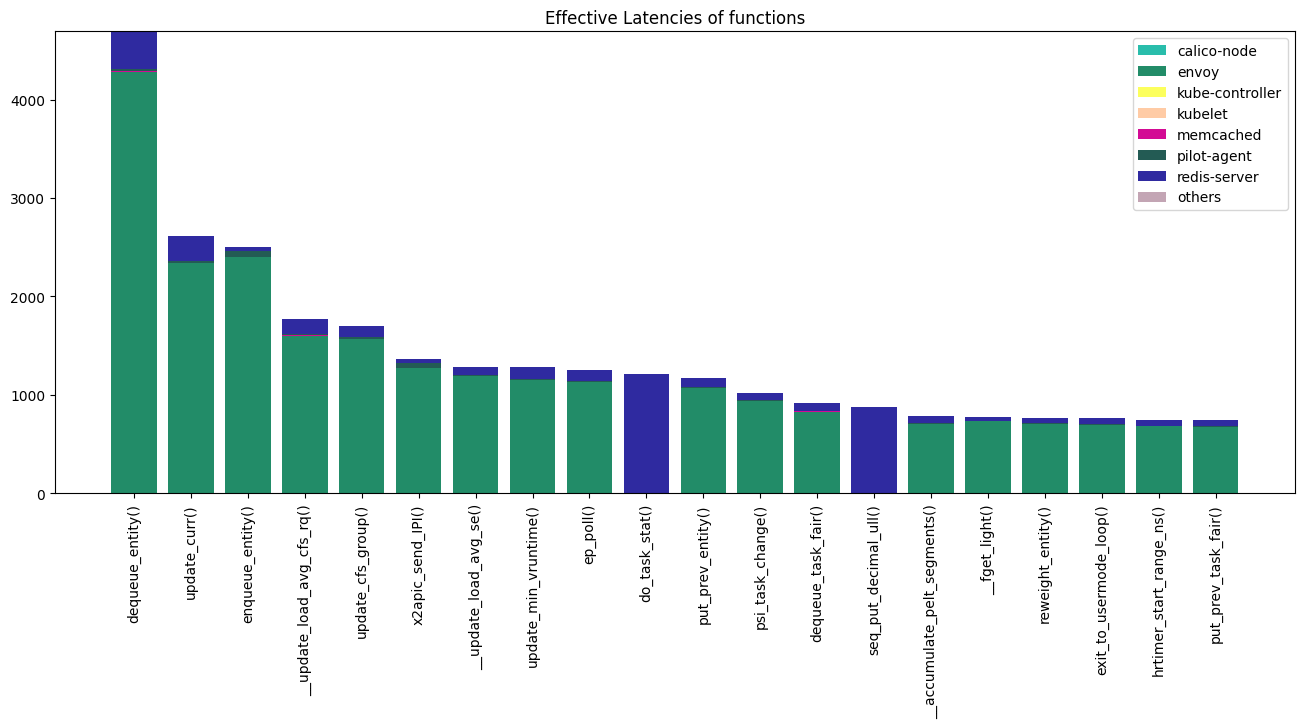

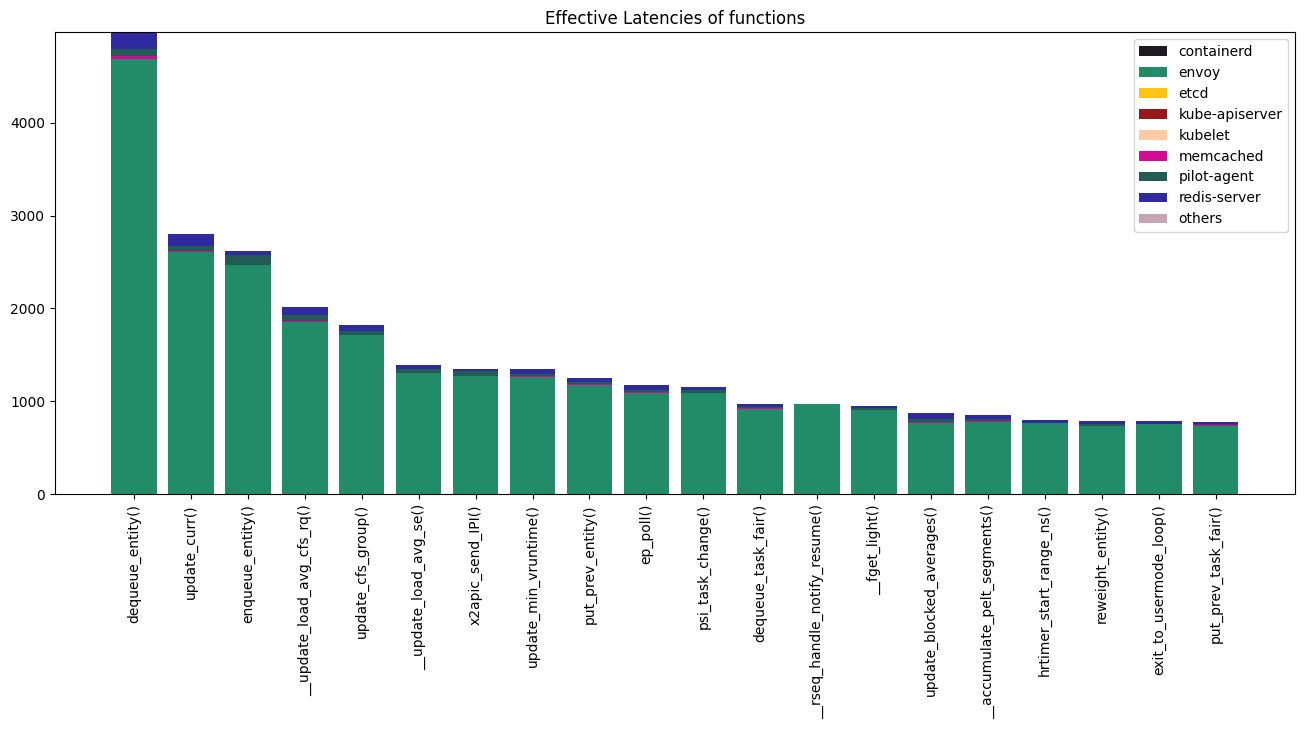

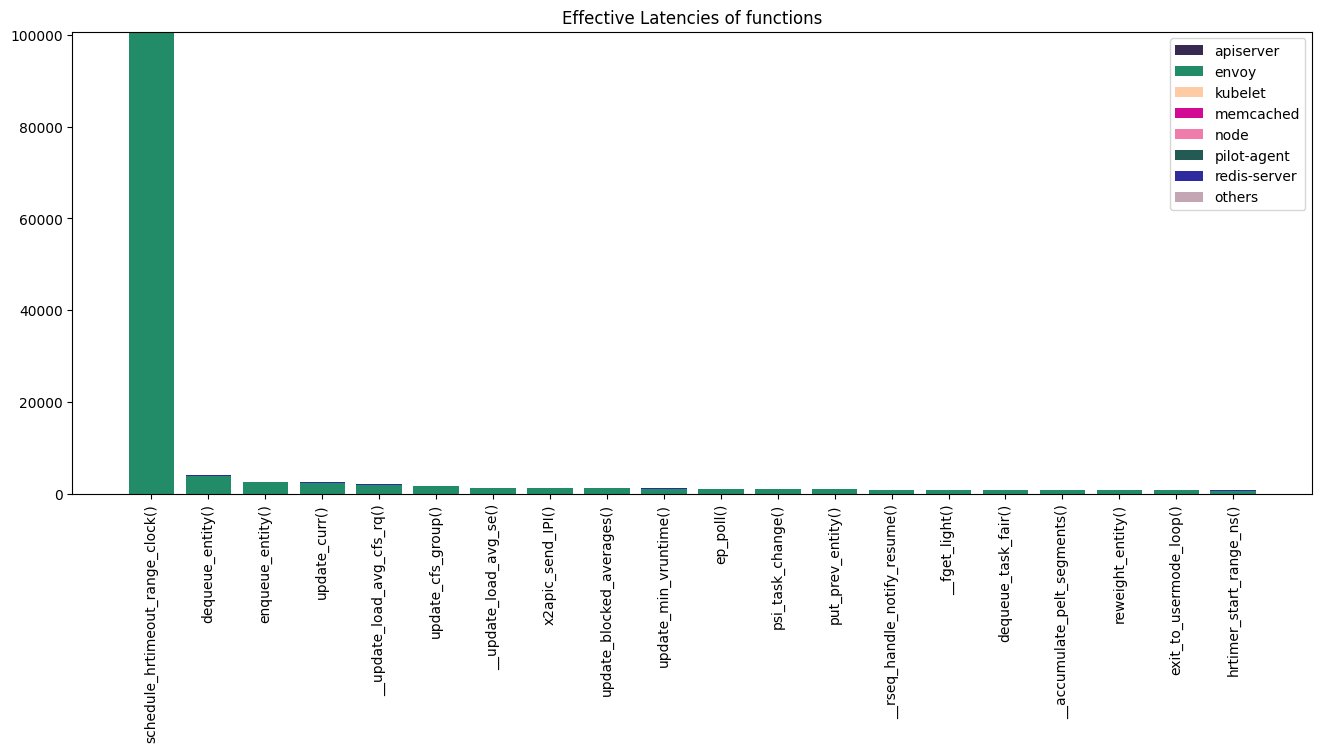

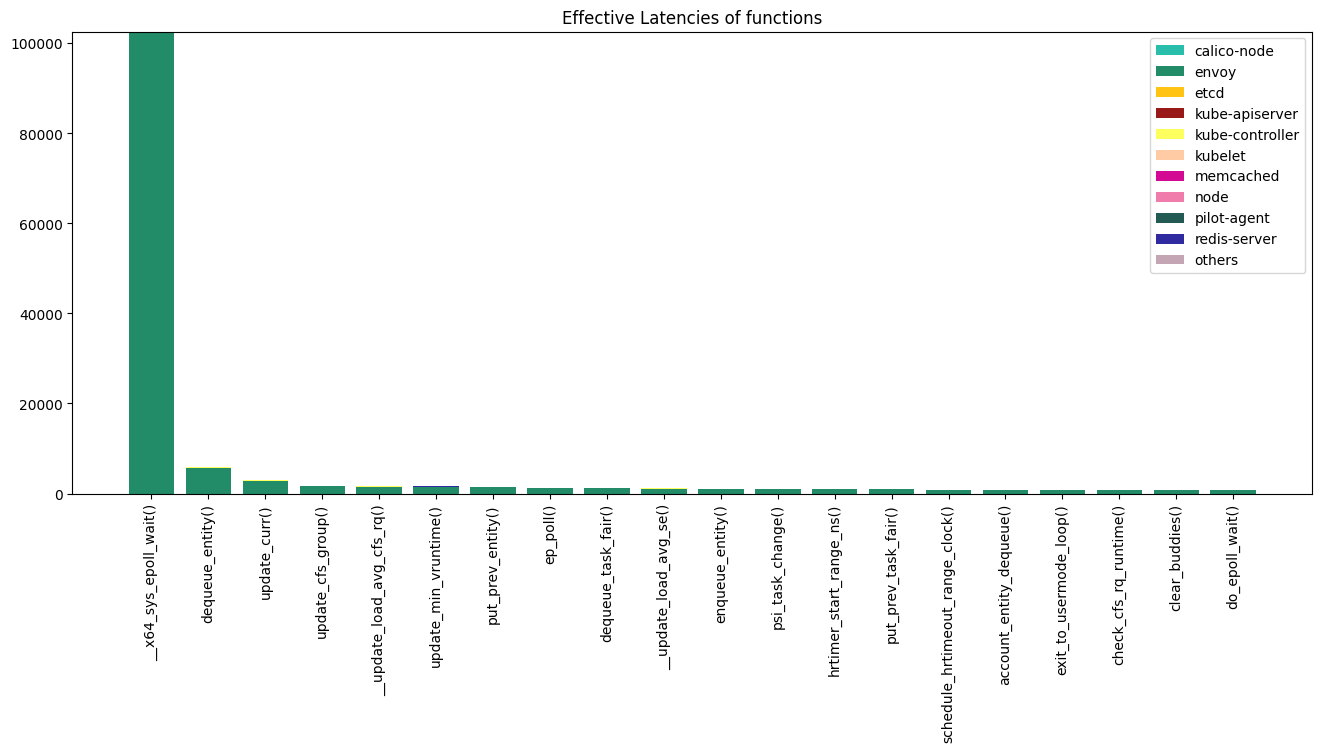

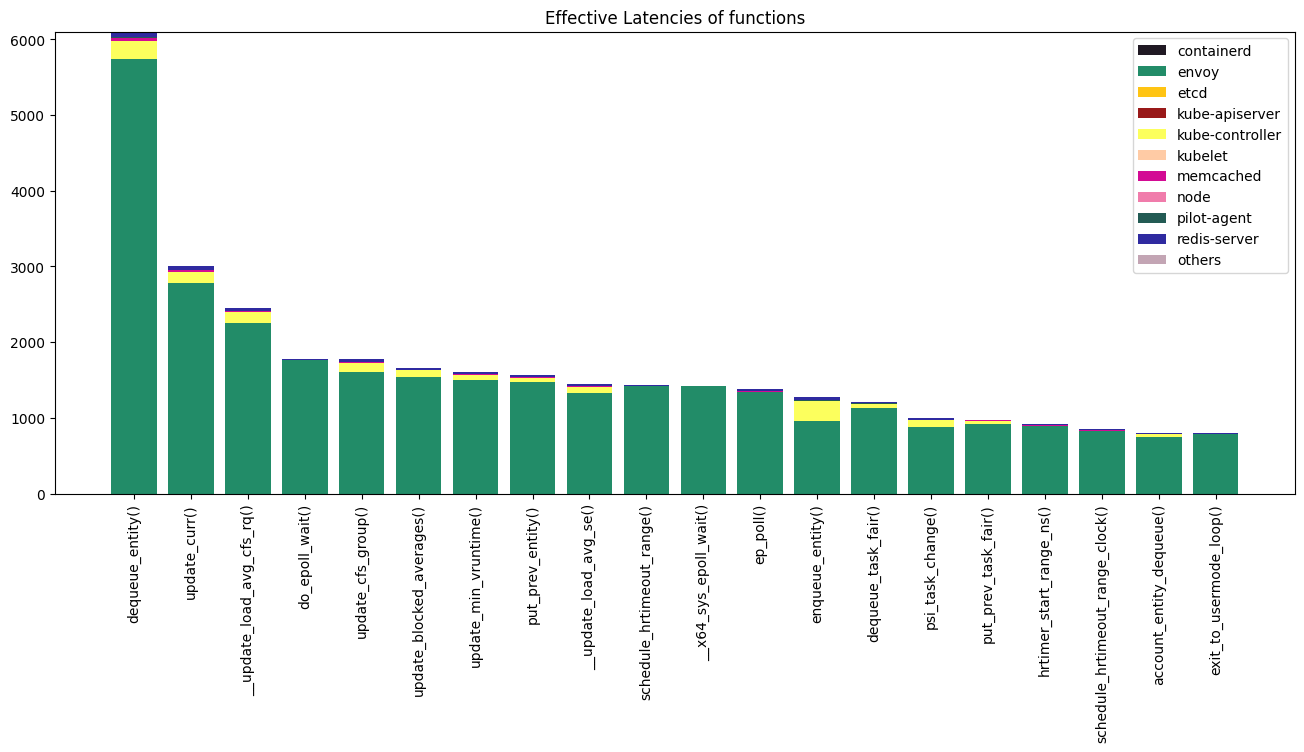

In [16]:
latencies = []
for i in range(NUM_RUNS):
    latencies.append(get_process_latency(runs[i],i))

for latency in latencies:
    plot_stacked_counts(latency, title="Effective Latencies of functions") # TODO: pick a better term

schedule_hrtimeout_range_clock()  and __x64_sys_epoll_wait() occuer at random points of time and pollute the data and are hence removed

{'schedule()', 'do_syscall_64()', 'schedule_hrtimeout_range_clock()', '__x64_sys_epoll_wait()', 'BLANK'}
{'schedule()', 'do_syscall_64()', 'schedule_hrtimeout_range_clock()', '__x64_sys_epoll_wait()', 'BLANK'}
{'schedule()', 'do_syscall_64()', 'schedule_hrtimeout_range_clock()', '__x64_sys_epoll_wait()', 'BLANK'}
{'schedule()', 'do_syscall_64()', 'schedule_hrtimeout_range_clock()', '__x64_sys_epoll_wait()', 'BLANK'}
{'schedule()', 'do_syscall_64()', 'schedule_hrtimeout_range_clock()', '__x64_sys_epoll_wait()', 'BLANK'}


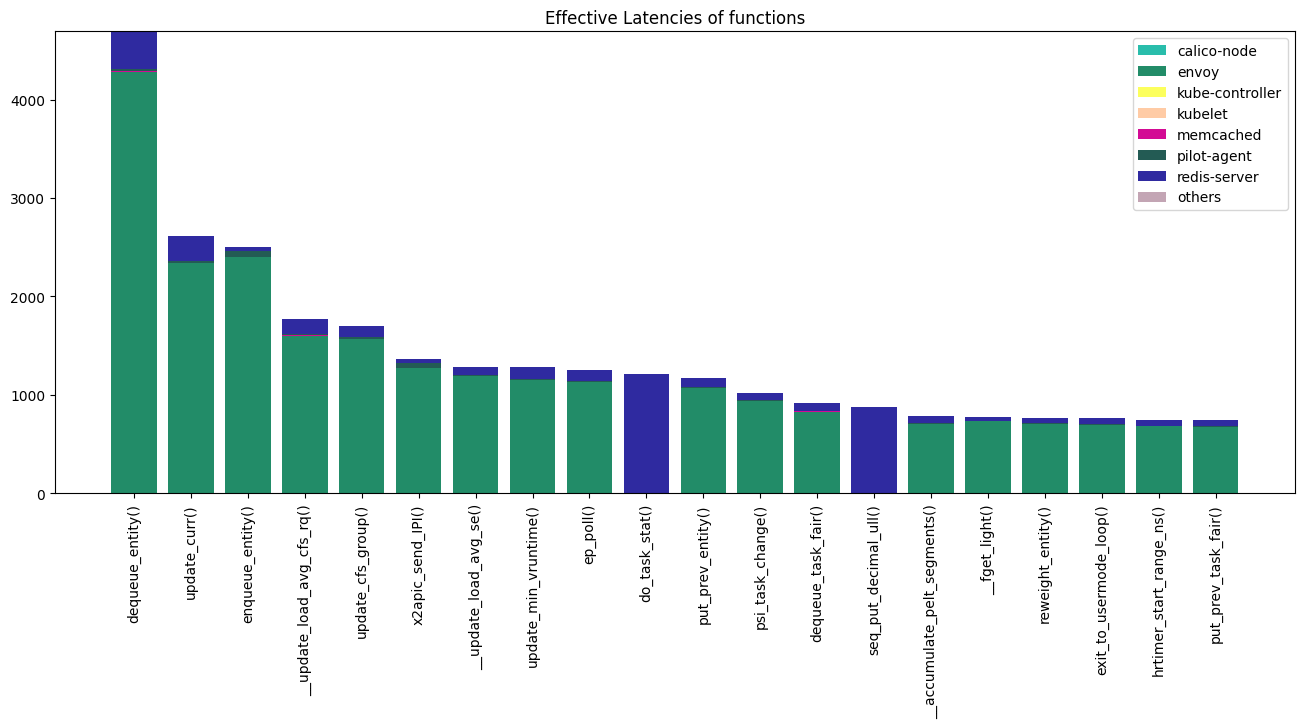

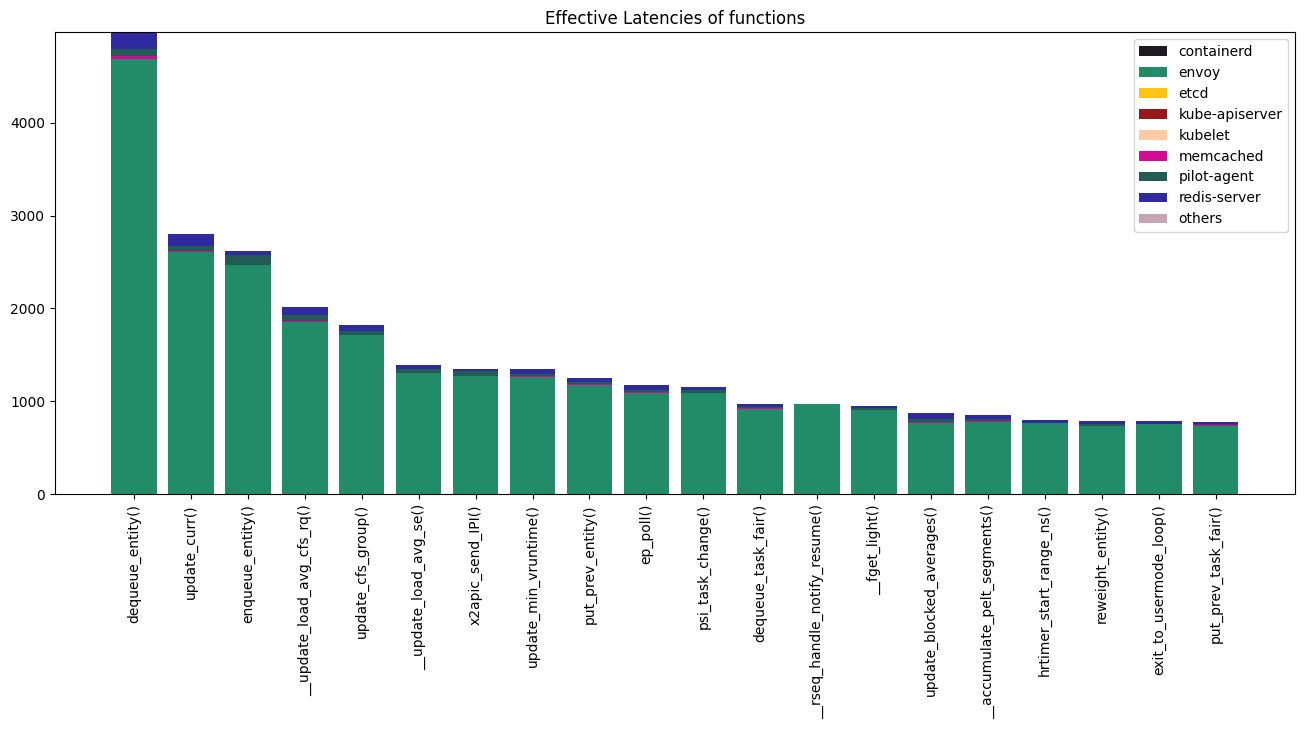

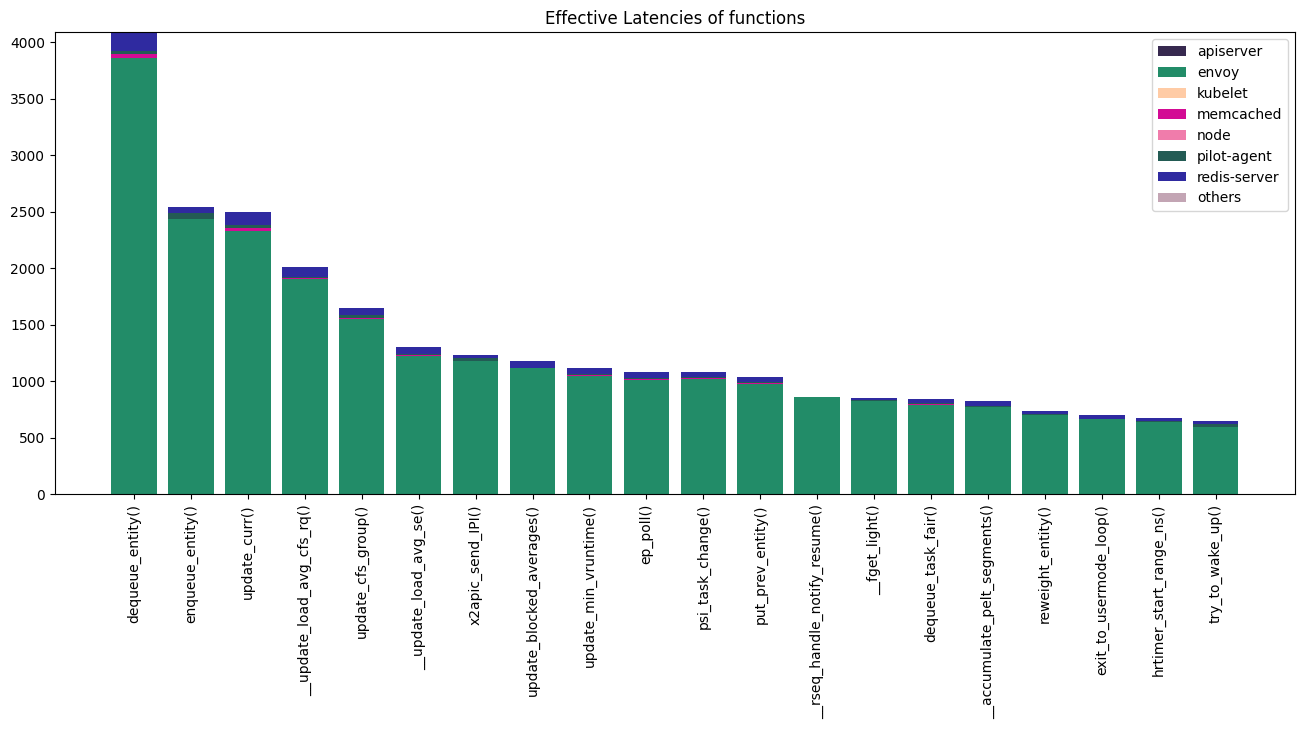

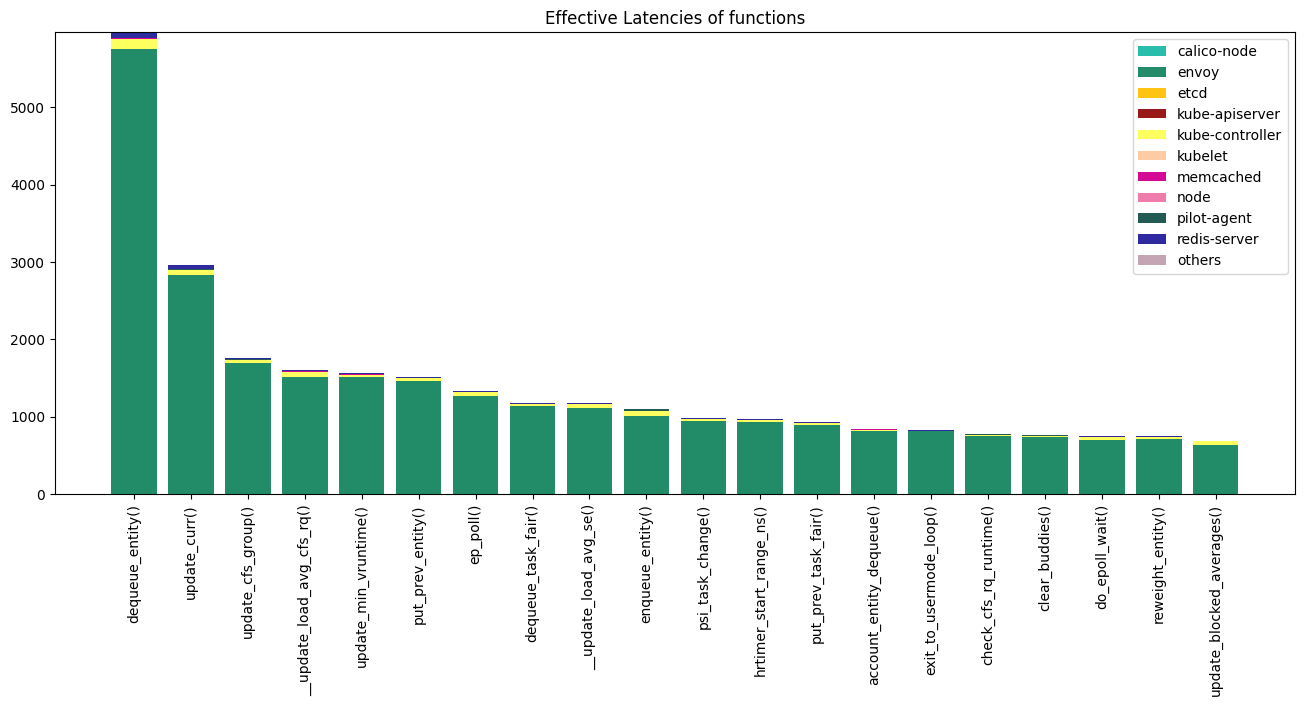

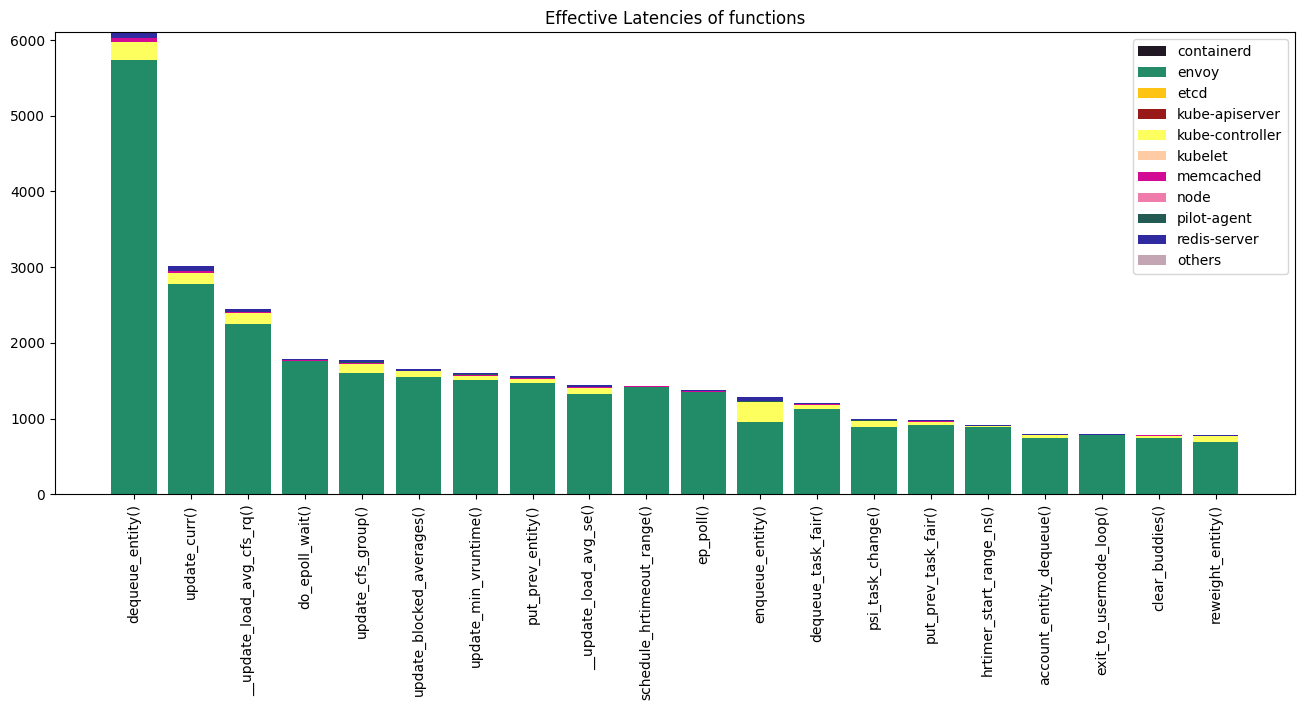

In [32]:
latencies = []
for i in range(NUM_RUNS):
    latencies.append(get_process_latency(runs[i], i, FUNC_BLACKLIST.union({"schedule_hrtimeout_range_clock()",'__x64_sys_epoll_wait()'})))

for latency in latencies:
    plot_stacked_counts(latency, title="Effective Latencies of functions") # TODO: pick a better term

* Dequeue_entity() is the most called function similar to the previous analyses
* update_curr() is the next more called function. It updates the current task's runtime statistics. This function was present in previous analysis as well but was shadowded by higher latency functions


In [38]:
# FUNC_BLACKLIST={"BLANK", "do_syscall_64()"}
def get_latency_by_pid(run,function=None):
    latency = {}
    
    def update_latency(pid,data):
        
        for call in data:
            function_name = call['function_name']
            if (not function or function_name == function) and (function_name not in FUNC_BLACKLIST):              
                latency[pid] = latency.get(pid, 0) + call['time']
                
                for child in call['children']:
                    latency[pid] -= child['time']

            update_latency(pid,call['children'])
    
    for pid,data in run.items():
        update_latency(pid,data)

    return latency

In [39]:
cnt=[]
for i in range(NUM_RUNS):
    count={}
    pid_map=get_pid_mapping(f'{WORKLOAD}/{i}.saved_cmdlines')
    latency=(get_latency_by_pid(runs[i],'dequeue_entity()'))
    for pid in latency.keys():
        if pid in pid_map:
            count[pid_map[pid]]=count.get(pid_map[pid],0)+latency[pid]
        else:
            cnt.append(pid)
    print(count)

{'redis-server': 379.92100000000084, 'envoy': 4275.188000000006, 'pilot-agent': 22.171000000000006, 'memcached': 14.336999999999996}
{'envoy': 4689.7450000000035, 'memcached': 29.278999999999996, 'pilot-agent': 70.44099999999996, 'redis-server': 183.4799999999999}
{'envoy': 3858.165000000002, 'memcached': 32.736999999999995, 'pilot-agent': 28.326999999999988, 'redis-server': 166.88600000000002}
{'pilot-agent': 12.281999999999998, 'envoy': 5749.179000000008, 'kube-controller': 134.92299999999992, 'memcached': 6.071999999999998, 'redis-server': 69.573}
{'envoy': 5738.439, 'pilot-agent': 4.962000000000001, 'redis-server': 75.109, 'memcached': 46.467, 'kube-controller': 237.4090000000017}


From the previous analysis it was noticed that the dequeue_entity() function was most called by the k8s processes but with istio it is mostly called by envoy

In [63]:
FUNC_BLACKLIST = {"BLANK", "do_syscall_64()","schedule()"}

def get_latency_by_pid(run,function=None):
    latency = {}
    
    def update_latency(pid,data):
        
        for call in data:
            function_name = call['function_name']
            if (not function or function_name == function) and (function_name not in FUNC_BLACKLIST):              
                latency[pid] = latency.get(pid, 0) + call['time']
                for child in call['children']:
                    latency[pid] -= child['time']

            update_latency(pid,call['children'])
    
    for pid,data in run.items():
        update_latency(pid,data)
        

    return latency

In [64]:
def plot_piechart(counts,title):
    count=counts.copy()
    todel=[]
    def percent(pct):
        if pct>0.5:
            return "{:1.3f}%".format(pct)
        else:
            return ""
    count['others']=0
    for p,latency in count.items():
        percentage_latency=(latency/sum(count.values()))*100
        if percentage_latency<1 and p!='others':
            count['others']=count.get('others',0)+latency
            todel.append(p)
    for i in todel:
        count.pop(i)
    # print(title)
    plt.figure(figsize=(6, 4))
    plt.pie(count.values(),labels=count.keys(),autopct=percent,radius=2,center=(0,2))
    plt.title(title,pad=100)
    plt.show()

{'redis-server': 17501.985000000182, 'envoy': 50112.453999999954, 'calico-node': 2.134, 'kubelet': 9.73, 'pilot-agent': 914.858999999899, 'kube-controller': 3.136, 'memcached': 110.8059999999581, 'pilot-discovery': 1.873, 'wrk:worker_0': 2.485}


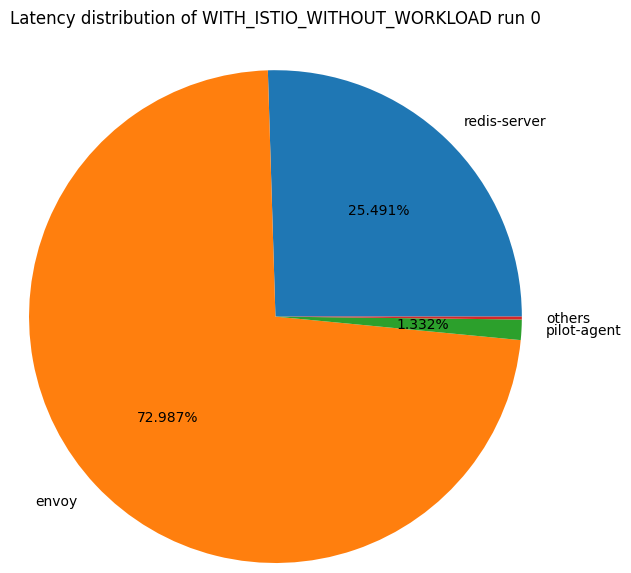

{'envoy': 55452.93700000081, 'kube-apiserver': 17.454, 'memcached': 271.8839999998305, 'pilot-agent': 2103.159000000449, 'kworker/7:2': 5.601, 'kubelet': 15.118, 'redis-server': 9026.945000000193, 'containerd': 1.603, 'containerd-shim': 2.234, 'etcd': 2.715}


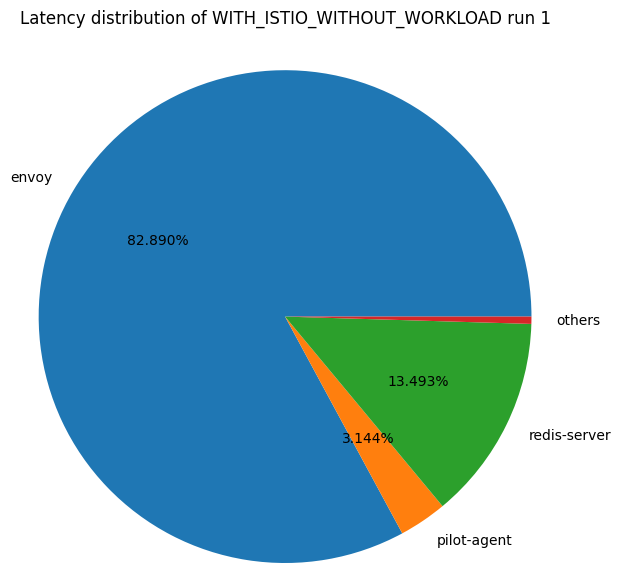

{'envoy': 159103.37600000045, 'memcached': 246.4109999996424, 'pilot-agent': 719.8030000000078, 'kubelet': 9.749, 'redis-server': 8475.532999999967, 'AccessLogFlush': 1.023, 'wrk:worker_1': 0.24, 'apiserver': 0.611, 'node': 10.24, 'wrk:worker_3': 2.4140000000000006, 'kworker/4:1': 0.26, 'ksoftirqd/2': 4.448, 'coredns': 0.781}


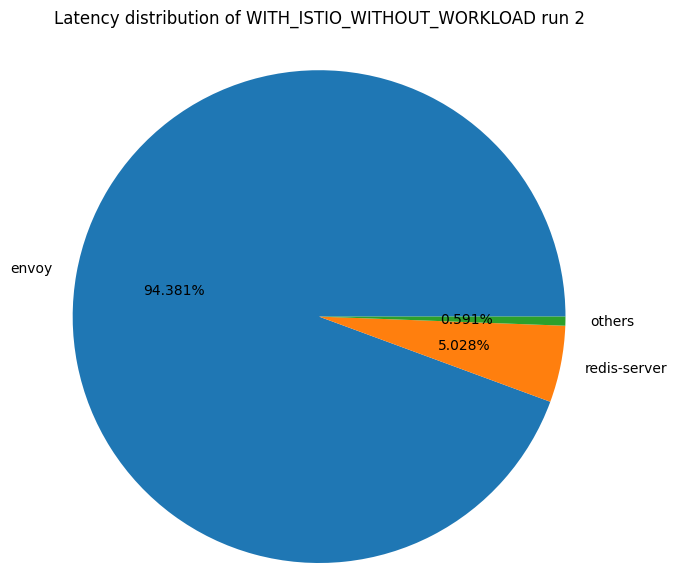

{'pilot-agent': 259.327000000162, 'envoy': 152645.18800000002, 'etcd': 14.377, 'kubelet': 2.8739999999999997, 'kube-controller': 1715.020000000006, 'wrk:worker_0': 6.461, 'kube-apiserver': 10.982, 'memcached': 63.941000000089375, 'redis-server': 3582.287999999979, 'wrk:worker_1': 4.328, 'node': 4.488, 'Backgro.kSource': 2.054, 'dog:workers_gua': 1.753, 'calico-node': 1.302, 'AccessLogFlush': 0.3}


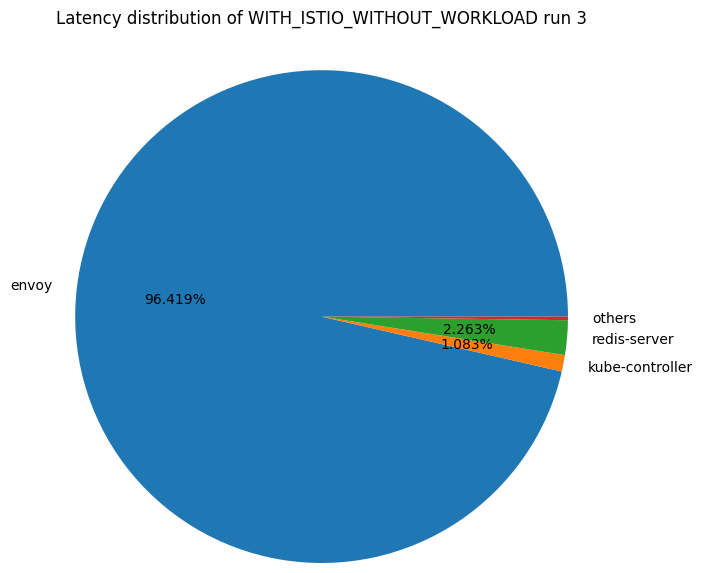

{'envoy': 54591.58100000019, 'node': 2.154, 'kube-apiserver': 5.772, 'containerd': 2.304, 'pilot-agent': 93.58800000000002, 'redis-server': 4654.137000000006, 'kube-controller': 3753.0840000000094, 'memcached': 321.76499999999885, 'wrk:worker_0': 3.457, 'AccessLogFlush': 1.633, 'kworker/1:2': 1.302, 'etcd': 2.555, 'ftdc': 2.354, 'wrk:worker_1': 2.6159999999999997, 'pilot-discovery': 3.096, 'dog:workers_gua': 1.6630000000000003, 'kubelet': 1.9929999999999999, 'kworker/0:5': 0.281}


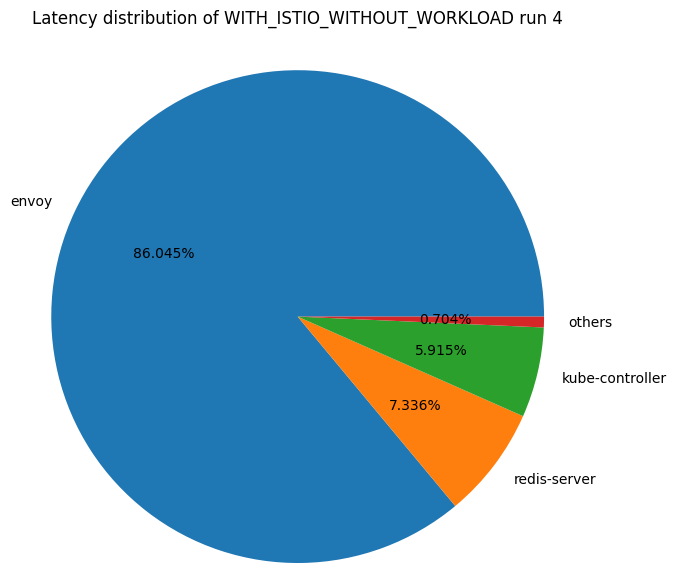

In [67]:
final_latency={}
counts={}
for i in range(NUM_RUNS):
    count={}
    pid_map=get_pid_mapping(f'{WORKLOAD}/{i}.saved_cmdlines')
    latency=(get_latency_by_pid(runs[i]))
    # print(latency)
    for pid in latency.keys():
        if pid in pid_map:
            count[pid_map[pid]]=count.get(pid_map[pid],0)+latency[pid]
    for key,val in count.items():
        if key in final_latency:
            final_latency[key]=final_latency.get(final_latency[key],0)+val
            counts[key]=counts.get(counts[key],0)+1
        else:
            final_latency[key]=val
            counts[key]=1
    print(count)
    plot_piechart(count,f"Latency distribution of {WORKLOAD} run {i}")

for k,v in final_latency.items():
    final_latency[k]=final_latency[k]/counts[k]

Envoy processes take up most of the time in the duration

{'do_syscall_64()', 'schedule()', 'BLANK'}


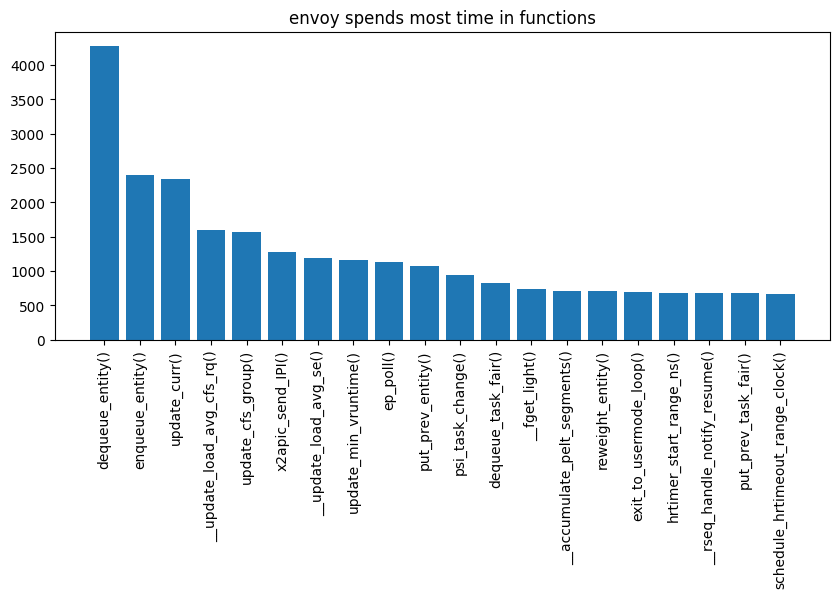

In [31]:
def plot_functions_in_process(run, run_no, process,maxnum=20 ):
    func_latencies=get_process_latency(run,run_no,FUNC_BLACKLIST.union({"schedule()"}))
    proc_latency={}
    for func,data in func_latencies.items():
        if(process in data.keys()):
            proc_latency[func]= data[process]
    maxnum = min(maxnum, len(proc_latency))
    x = sorted(list(proc_latency.keys()), key=lambda x: proc_latency[x], reverse=True)[ :maxnum]
    y= [proc_latency[_] for _ in x]
    plt.figure(figsize=(10, 4))
    plt.xticks(np.arange(len(x)), x, rotation=90)
    plt.title(f'{process} spends most time in functions')
    plt.bar(x, y)
    plt.show()
    del x, y
            
plot_functions_in_process(runs[0],0,'envoy')

* Envoy spends most of the time in dequeue and enqueue. These functions should not be taken into consideration when running the workload
* Though the most latency functions are same with and without istio, the cause of the overhead is different and the overhead itself is more in istio.


##### Comparing between without and with istio


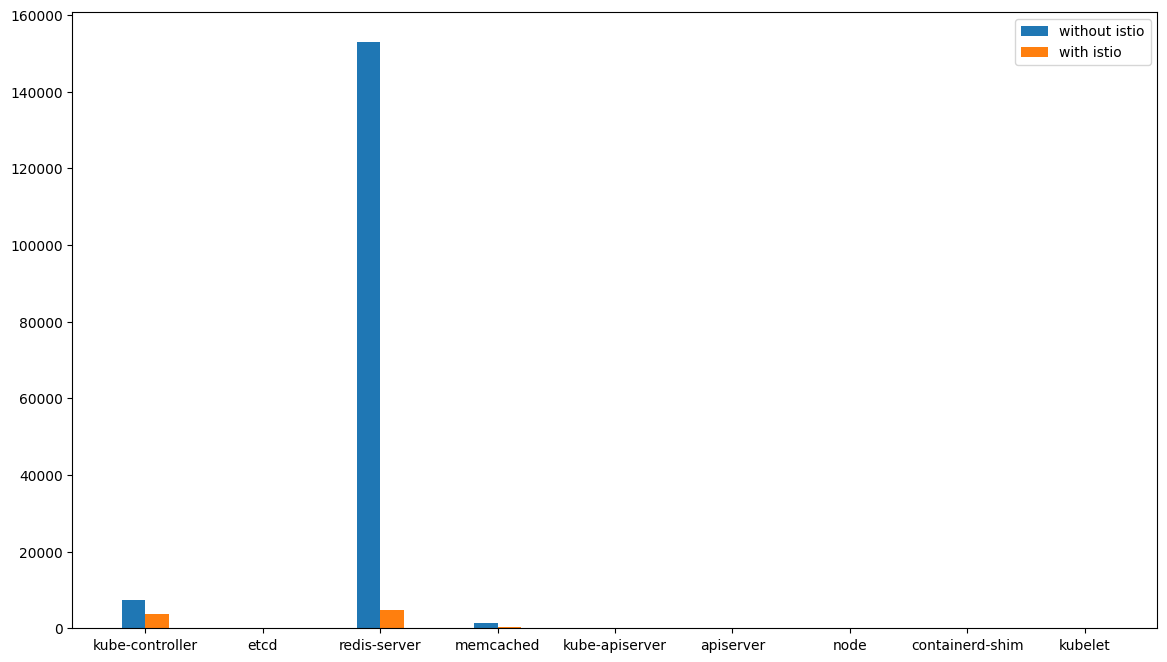

In [68]:
without_istio={'kube-controller': 7359.38199999985, 'etcd': 1.953, 'redis-server': 153041.63899999956, 'memcached': 1397.080999999229, 'kube-apiserver': 4.709, 'apiserver': 2.114, 'node': 3.9370000000000003, 'containerd-shim': 0.742, 'kube-proxy': 376.22100000090535, 'kworker/4:0': 0.29, 'kworker/7:0': 3.176, 'kworker/1:1': 1.512, 'ip6tables': 3946.9540000000015, 'kworker/0:0': 0.34, 'operator': 1.573, 'kworker/2:0': 0.251, 'kubelet': 6.412000000000001, 'kworker/3:2': 0.21}
with_istio = final_latency
proc=[]
withoutIstio=[]
withIstio=[]
for i in without_istio:
    if i in with_istio:
        proc.append(i)
        withoutIstio.append(without_istio[i])
        withIstio.append(with_istio[i])
x = np.arange(len(proc))
plt.figure(figsize=(14, 8))
plt.bar(x-0.1, withoutIstio,0.2)
plt.bar(x+0.1, withIstio,0.2)
plt.xticks(x,proc)
plt.legend(['without istio','with istio'])


### In conclusion without istio redis adds the most latency but with istio it is envoy. the latency added per function by redis reduces with istio but overall the total latency per function increases with istio